In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '/home/ksf293/external')
import illustris_python as il

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import scalars
import plotter

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = True
plot_dir = '../plots/plots_2021-01-28'

# r_edges (TNG50-4: L=35 Mpc/h, N_part=270^3, mean interparticle spacing = 35/270 = 0.13 Mpc/h = 130 kpc/h)
#r_edges = np.logspace(np.log10(1), np.log10(1000), 7) 
#r_edges = np.array([0, 1000])
r_edges = np.array([0, 1])
#r_edges = np.logspace(np.log10(0.01), np.log10(10), 5) 
#r_edges = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
r_units = 'r200'
print(r_edges)

m_order_max = 1
x_order_max = 0 # for scalars, only 0 or 2 x orders
l_arr = scalars.get_needed_ls_scalars(m_order_max, x_order_max)

logy = False
unc_tag = '_unc0.1M'
runit_tag = '_r200edges'
y_scalar_feature_name='mass_hydro_subhalo_star'
y_tag = '_msubhalo'

logy_tag = ''
if logy:
    logy_tag = '_logy'
save_tag = f'_xordmax{x_order_max}_mordmax{m_order_max}_rbins{len(r_edges)-1}{logy_tag}{unc_tag}{runit_tag}{y_tag}'

[0 1]


In [3]:
mass_multiplier = 1e10

In [4]:
featurizer = Featurizer(r_edges, r_units=r_units)
featurizer.read_simulations()
featurizer.match_twins()
featurizer.select_halos()
featurizer.add_info_to_halo_dicts()

In [5]:
print(featurizer.N_halos)

2344


In [6]:
featurizer.compute_geometric_features(l_arr)

In [8]:
featurizer.compute_scalar_features(m_order_max, x_order_max)
featurizer.set_y_labels(y_scalar_feature_name='mass_hydro_subhalo_star')

In [9]:
print(featurizer.n_features)

2


In [10]:
uncertainties = 0.1*featurizer.y_scalar # uncertainties are 0.1*M_stellar (M_stellar is our label)

In [11]:
fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                featurizer.x_scalar_dicts, uncertainties=uncertainties)
fitter.split_train_test()
fitter.scale_and_fit(logy=logy)

In [12]:
fitter.predict()

In [13]:
y_true = fitter.y_scalar_test*mass_multiplier
y_pred = fitter.y_scalar_pred*mass_multiplier
msfe_test = np.mean(((y_pred - y_true)/y_true)**2)

y_train = fitter.y_scalar_train*mass_multiplier
y_train_pred = (fitter.x_scalar_train @ fitter.theta_scalar)*mass_multiplier
chi2 = fitter.chi2
chi2_adjusted = np.sqrt(np.sum(((y_train_pred - y_train)/fitter.uncertainties_train)**2))
print(f"{chi2_adjusted:.3e}")
print(fitter.res_scalar[1])
print(f"chi^2 = {fitter.chi2:.3e}, N_train={fitter.n_train}")
print(f"msfe = {msfe_test:.3e}, N_test={fitter.n_test}")

3.094e+12
[]
chi^2 = 7.451e-09, N_train=1876
msfe = 5.386e-01, N_test=468


In [14]:
print("In training set:")
print(f"Total number of halos: {fitter.n_train}")
print(f"Number of zero-stellar-mass halos: {fitter.n_train - np.count_nonzero(fitter.y_scalar_train)}")
print(f"Min/max stellar mass: {min(fitter.y_scalar_train)*mass_multiplier:.3e} / {max(fitter.y_scalar_train)*mass_multiplier:.3e}")
print(f"Minimum nonzero mass: {min(fitter.y_scalar_train[np.nonzero(fitter.y_scalar_train)[0]])*mass_multiplier:.3e}")

In training set:
Total number of halos: 1876
Number of zero-stellar-mass halos: 0
Min/max stellar mass: 4.349e+06 / 9.169e+11
Minimum nonzero mass: 4.349e+06


In [15]:
print("In test set:")
print(f"Total number of halos: {fitter.n_test}")
print(f"Number of zero-stellar-mass halos: {fitter.n_test - np.count_nonzero(fitter.y_scalar_test)}")
print(f"Min/max stellar mass: {min(fitter.y_scalar_test)*mass_multiplier:.3e} / {max(fitter.y_scalar_test)*mass_multiplier:.3e}")
print(f"Minimum nonzero mass: {min(fitter.y_scalar_test[np.nonzero(fitter.y_scalar_test)[0]])*mass_multiplier:.3e}")
print()
print(f"Minimum nonzero predicted mass: {min(fitter.y_scalar_pred[np.nonzero(fitter.y_scalar_pred)[0]])*mass_multiplier:.3e}")
print(f"Minimum positive predicted mass: {min(fitter.y_scalar_pred[np.where(fitter.y_scalar_pred > 0)[0]])*mass_multiplier:.3e}")
print(f"Number mass predictions with m<0:", len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0]))
print(f"Number mass predictions with |m|<1e5:", len(np.where(abs(fitter.y_scalar_pred*mass_multiplier) < 1e5)[0]))

In test set:
Total number of halos: 468
Number of zero-stellar-mass halos: 0
Min/max stellar mass: 6.473e+06 / 6.675e+10
Minimum nonzero mass: 6.473e+06

Minimum nonzero predicted mass: 1.180e+07
Minimum positive predicted mass: 1.180e+07
Number mass predictions with m<0: 0
Number mass predictions with |m|<1e5: 0


In [16]:
featurizer.x_scalar_features.shape
print(featurizer.y_scalar.shape)
print(np.min(featurizer.y_scalar), np.max(featurizer.y_scalar))
print(np.min(featurizer.x_scalar_features[:,1]), np.max(featurizer.x_scalar_features[:,1]))

(2344,)
0.0004349329392425716 91.685302734375
0.0 13203.328601978441


(100000000.0, 100000000000000.0)

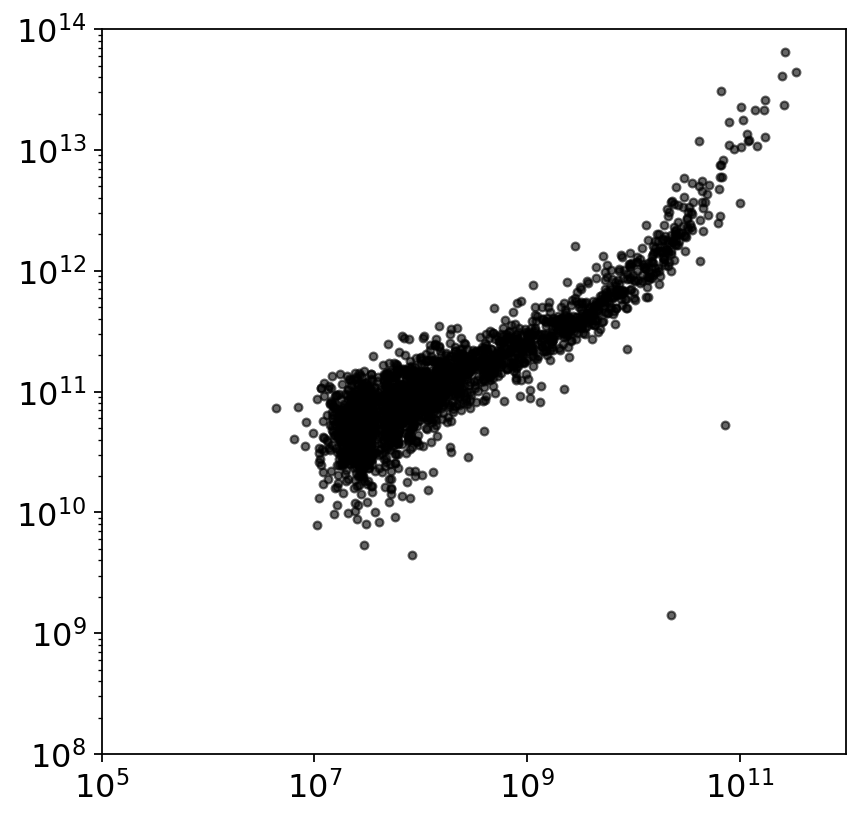

In [17]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
  
# main scatter plotting
plt.scatter(featurizer.y_scalar*mass_multiplier, featurizer.x_scalar_features[:,1]*mass_multiplier, s=12, alpha=0.6, c='k')
plt.xscale('log')
plt.yscale('log')
#ax.set_aspect('equal')

plt.xlim(1e5, 1e12)
plt.ylim(1e8, 1e14)

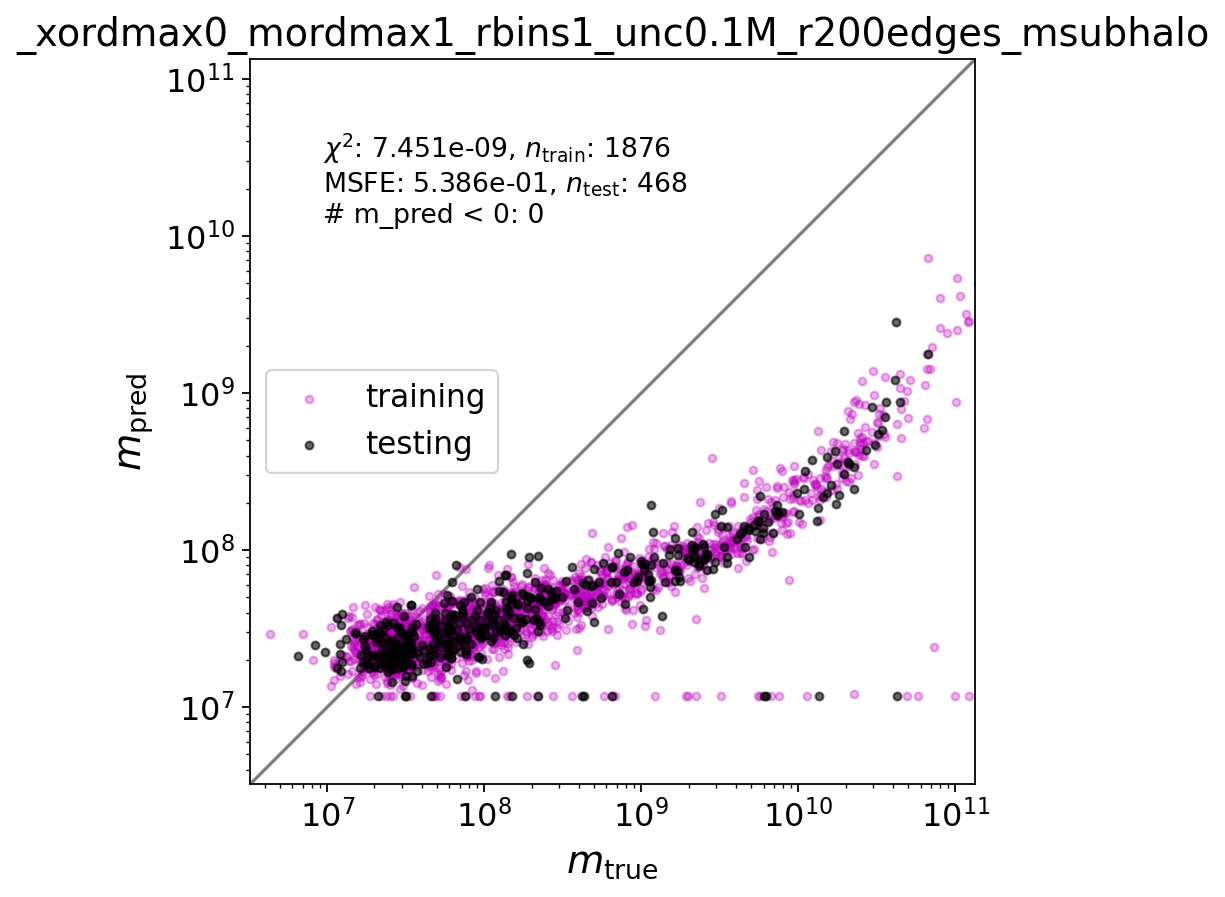

In [18]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
  
# main scatter plotting
plt.scatter(y_train, y_train_pred, s=12, alpha=0.3, c='m', label='training')
plt.scatter(y_true, y_pred, s=12, alpha=0.6, c='k', label='testing')


# get limits, plot true line
m_minmin = min(min(y_true[np.where(y_true > 0)]), 
               min(y_pred[np.where(y_pred > 0)]))
m_maxmax = max(max(y_true[np.where(y_true > 0)]), 
               max(y_pred[np.where(y_pred > 0)]))
true_line = np.linspace(0.5*m_minmin, 2*m_maxmax)
plt.plot(true_line, true_line, color='grey', zorder=0)

# labels & adjustments
plt.xlabel(r'$m_\mathrm{true}$')
plt.ylabel(r'$m_\mathrm{pred}$')
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.xlim(0.5*m_minmin, 2*m_maxmax)
plt.ylim(0.5*m_minmin, 2*m_maxmax)

n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
plt.text(0.1, 0.9, fr'$\chi^2$: {chi2:.3e}, $n_\mathrm{{train}}$: {fitter.n_train}' '\n'
                   fr'MSFE: {msfe_test:.3e}, $n_\mathrm{{test}}$: {fitter.n_test}' '\n'
                   fr'# m_pred < 0: {n_neg}', 
         transform=ax.transAxes, verticalalignment='top', fontsize=12)
plt.title(save_tag)
plt.legend(loc='center left', fontsize=14)

# save
save_fn = f'mass_recovery{save_tag}.pdf'
if save_plots:
      plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

(array([233., 112.,  67.,  26.,  19.,   3.,   2.,   1.,   1.,   4.]),
 array([-0.99972262, -0.67133982, -0.34295701, -0.01457421,  0.3138086 ,
         0.6421914 ,  0.97057421,  1.29895701,  1.62733982,  1.95572262,
         2.28410543]),
 [<matplotlib.patches.Polygon at 0x14879ef14910>])

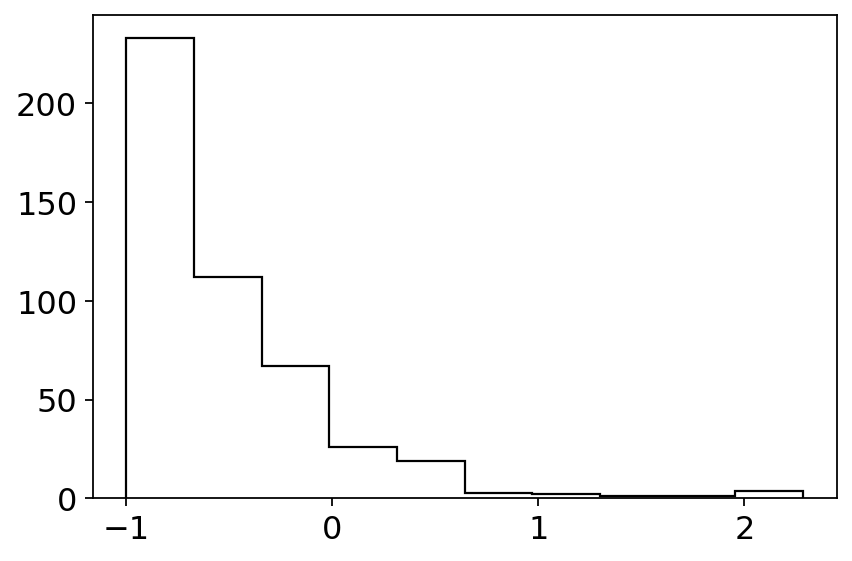

In [19]:
plt.hist((y_pred - y_true)/y_true, histtype='step', color='k')

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 468.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-100.        ,  -89.47368421,  -78.94736842,  -68.42105263,
         -57.89473684,  -47.36842105,  -36.84210526,  -26.31578947,
         -15.78947368,   -5.26315789,    5.26315789,   15.78947368,
          26.31578947,   36.84210526,   47.36842105,   57.89473684,
          68.42105263,   78.94736842,   89.47368421,  100.        ]),
 [<matplotlib.patches.Polygon at 0x14879f058ee0>])

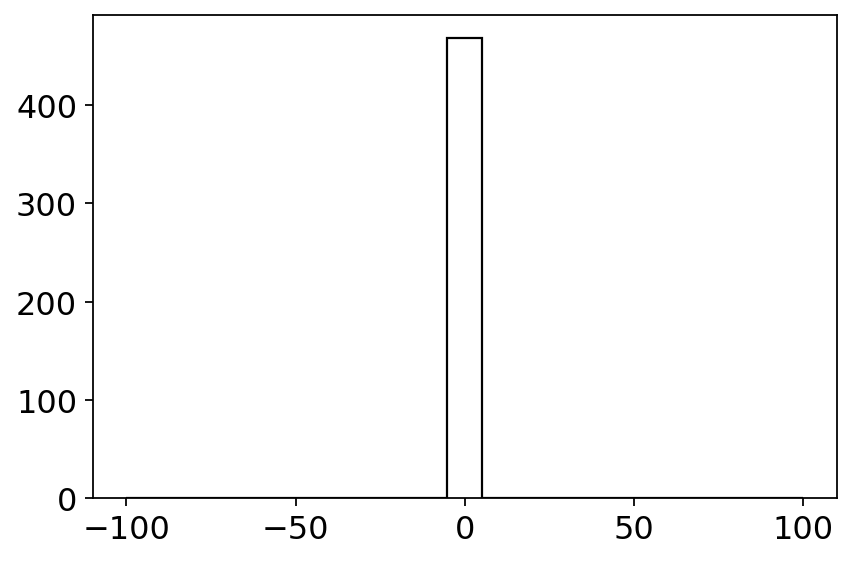

In [20]:
bins = np.linspace(-100, 100, 20)
plt.hist((y_pred - y_true)/y_true, bins=bins, histtype='step', color='k')

(array([  1.,   0.,   0.,   3.,   4.,   4.,   4.,  12.,  12., 428.]),
 array([-6.49882396e+10, -5.84867246e+10, -5.19852095e+10, -4.54836944e+10,
        -3.89821794e+10, -3.24806643e+10, -2.59791493e+10, -1.94776342e+10,
        -1.29761191e+10, -6.47460408e+09,  2.69109792e+07]),
 [<matplotlib.patches.Polygon at 0x1487c411ba00>])

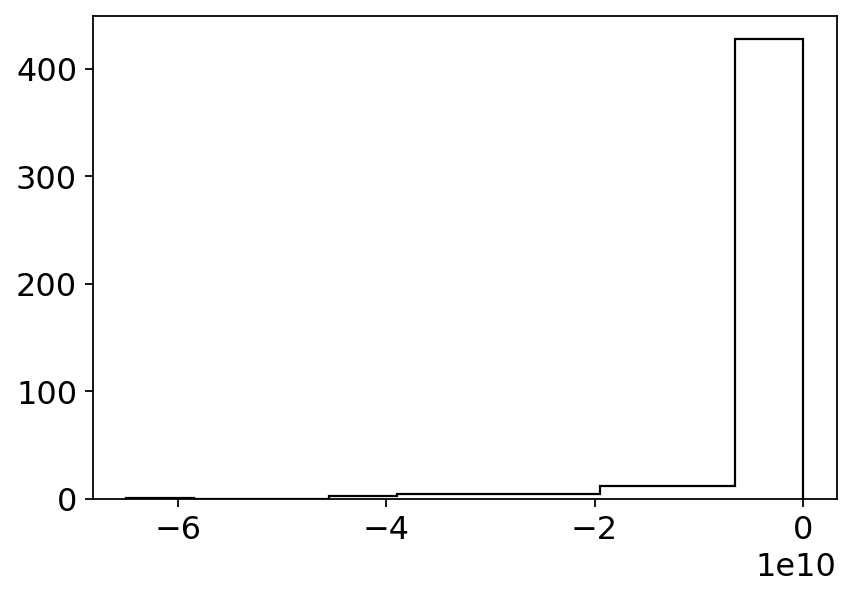

In [21]:
plt.hist((y_pred - y_true), histtype='step', color='k')

## Figure out zero-mass features

[350, 668, 808, 1797, 1994, 2066]


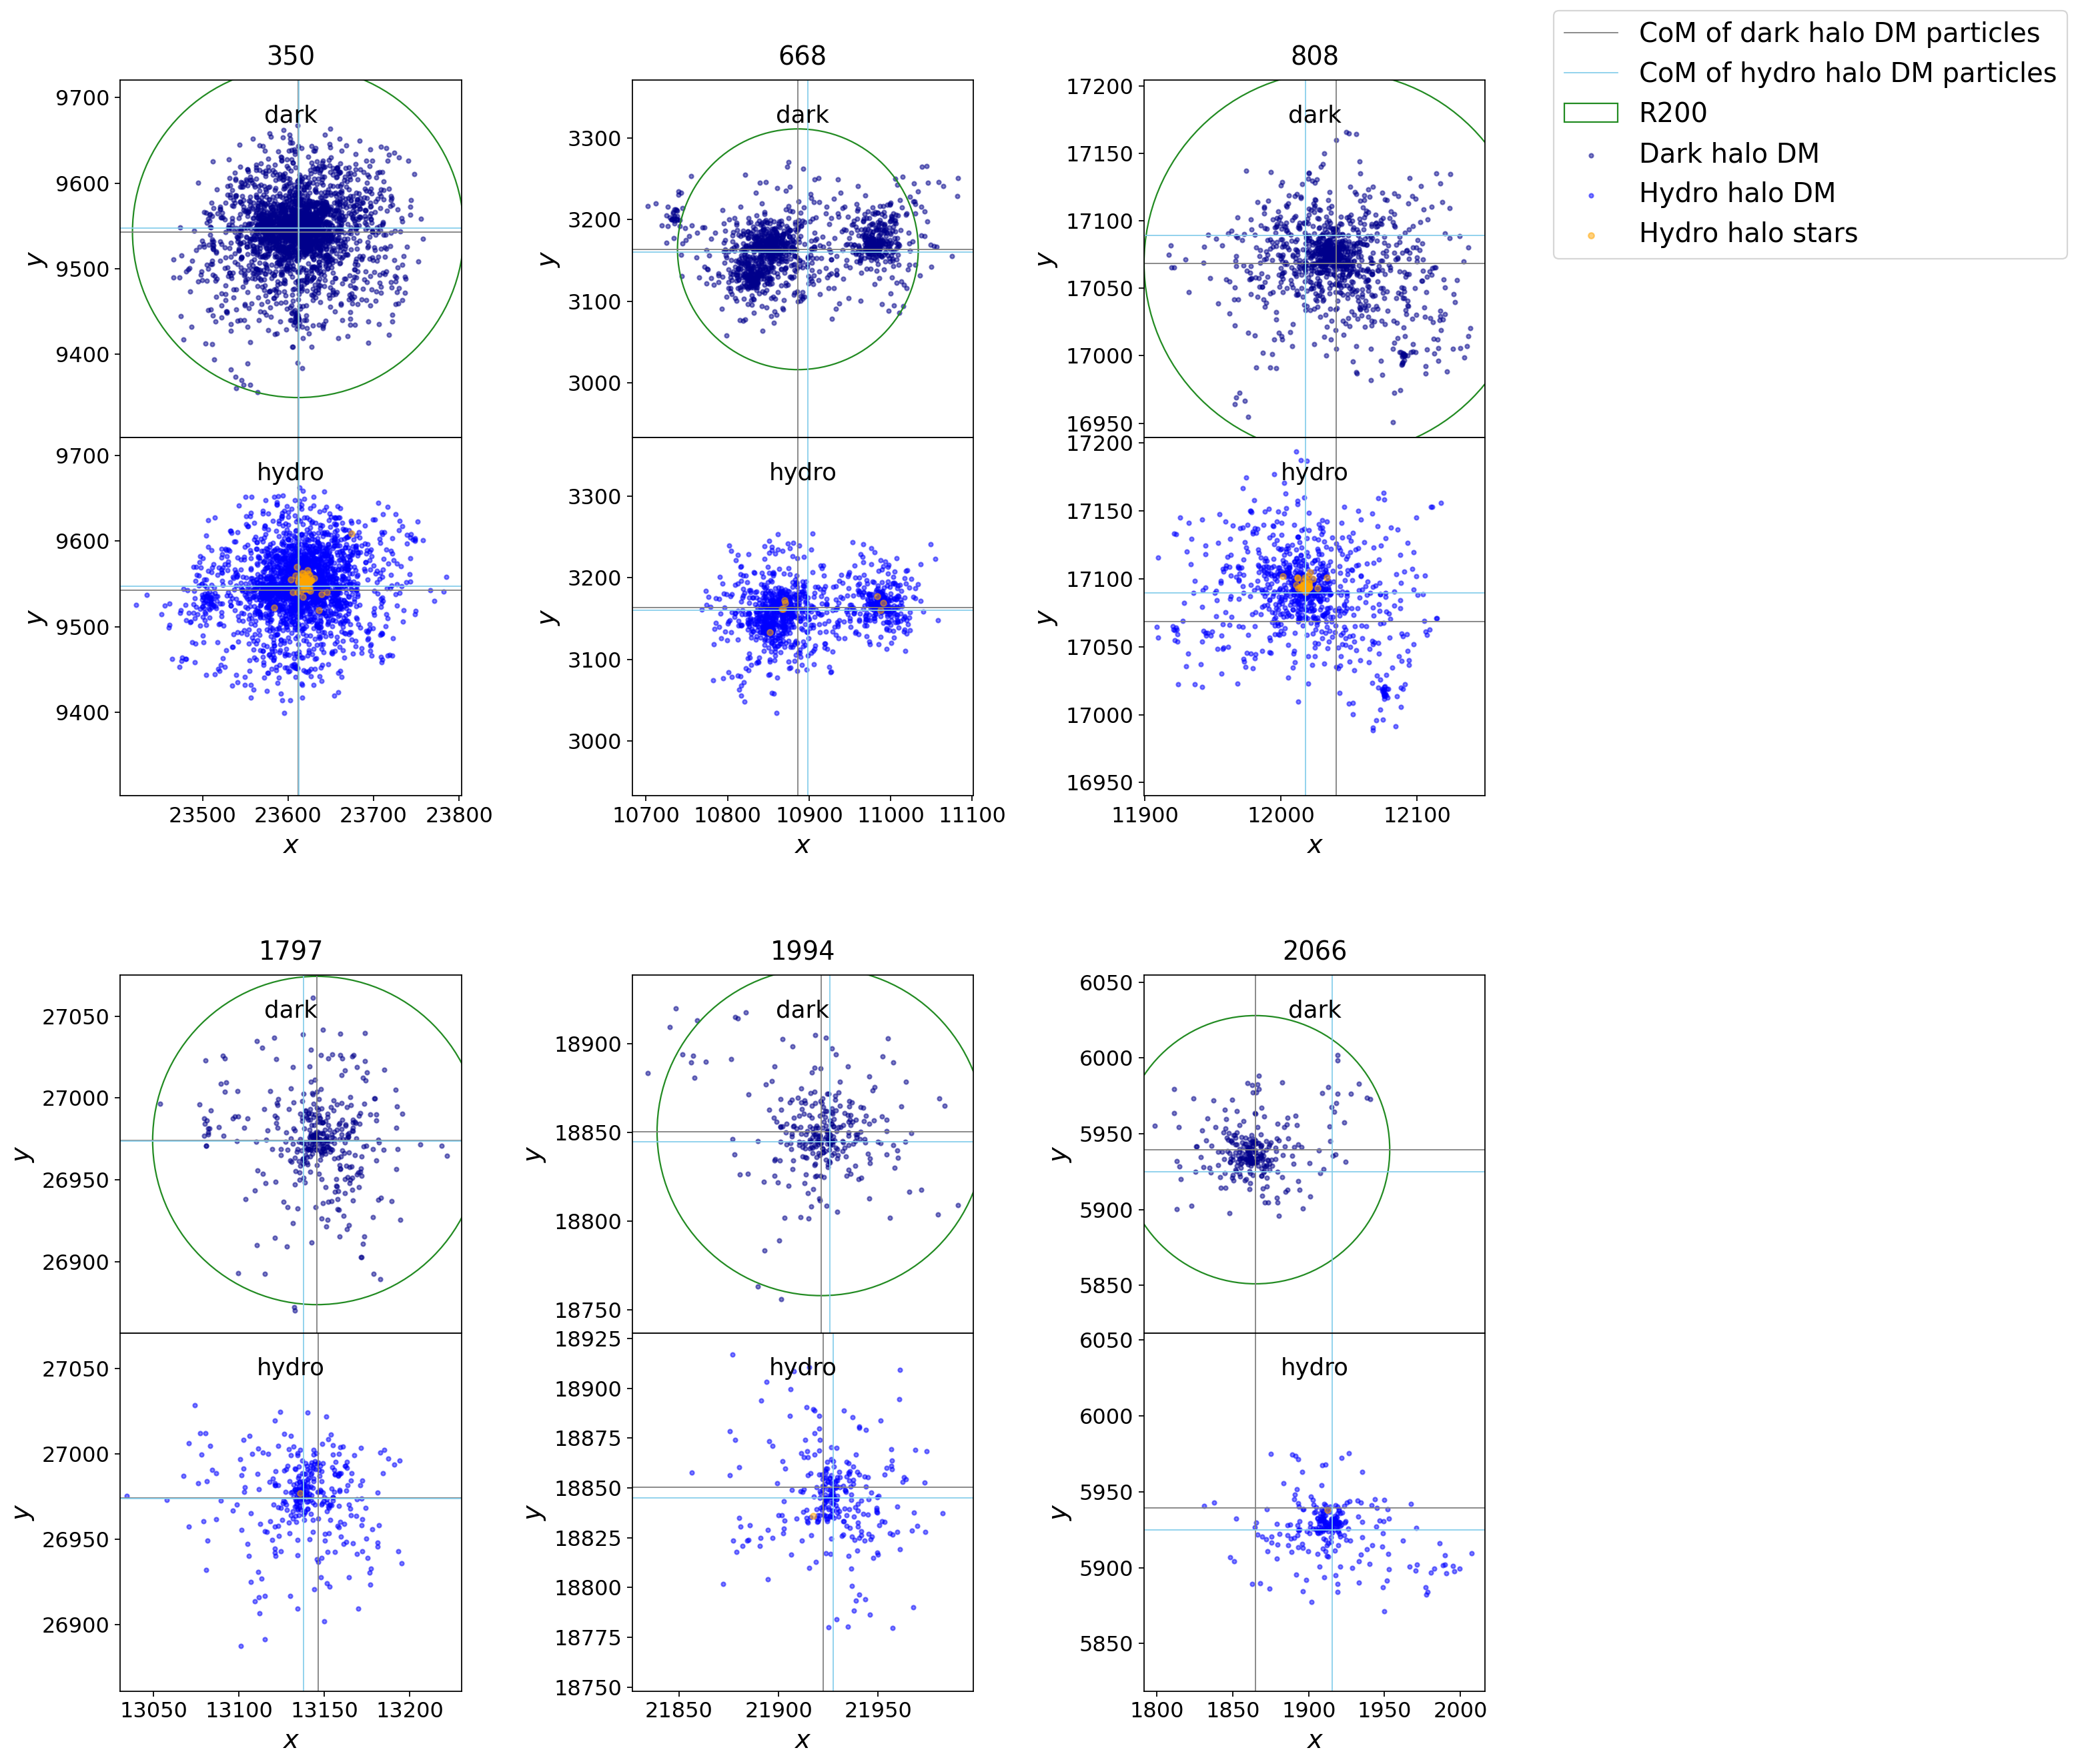

In [22]:
nrows_outer, ncols_outer = 2, 3
n_plots = nrows_outer * ncols_outer

# random sample
np.random.seed(42)
idxs_rand = sorted(np.random.choice(featurizer.N_halos, size=n_plots, replace=False))

halo_dicts_rand = featurizer.halo_dicts[idxs_rand]
titles = idxs_rand[:n_plots]
print(titles)
plotter.plot_halos_dark_and_hydro(halo_dicts_rand, nrows_outer, ncols_outer, titles)

In [23]:
m0 = featurizer.x_scalar_features[:,1]
idxs_m0_zero = np.where(m0==0)[0]
print(idxs_m0_zero)

[   5   11   40   49   84  157  185  188  196  222  246  257  258  292
  319  334  458  516  534  597  622  637  692  737  759  814  823  829
  888  900  974 1004 1042 1045 1115 1144 1219 1265 1297 1332 1338 1446
 1494 1512 1597 1864 1905 1920 2051 2117 2147 2165 2244]


[  5  11  40  49  84 157 185 188 196]


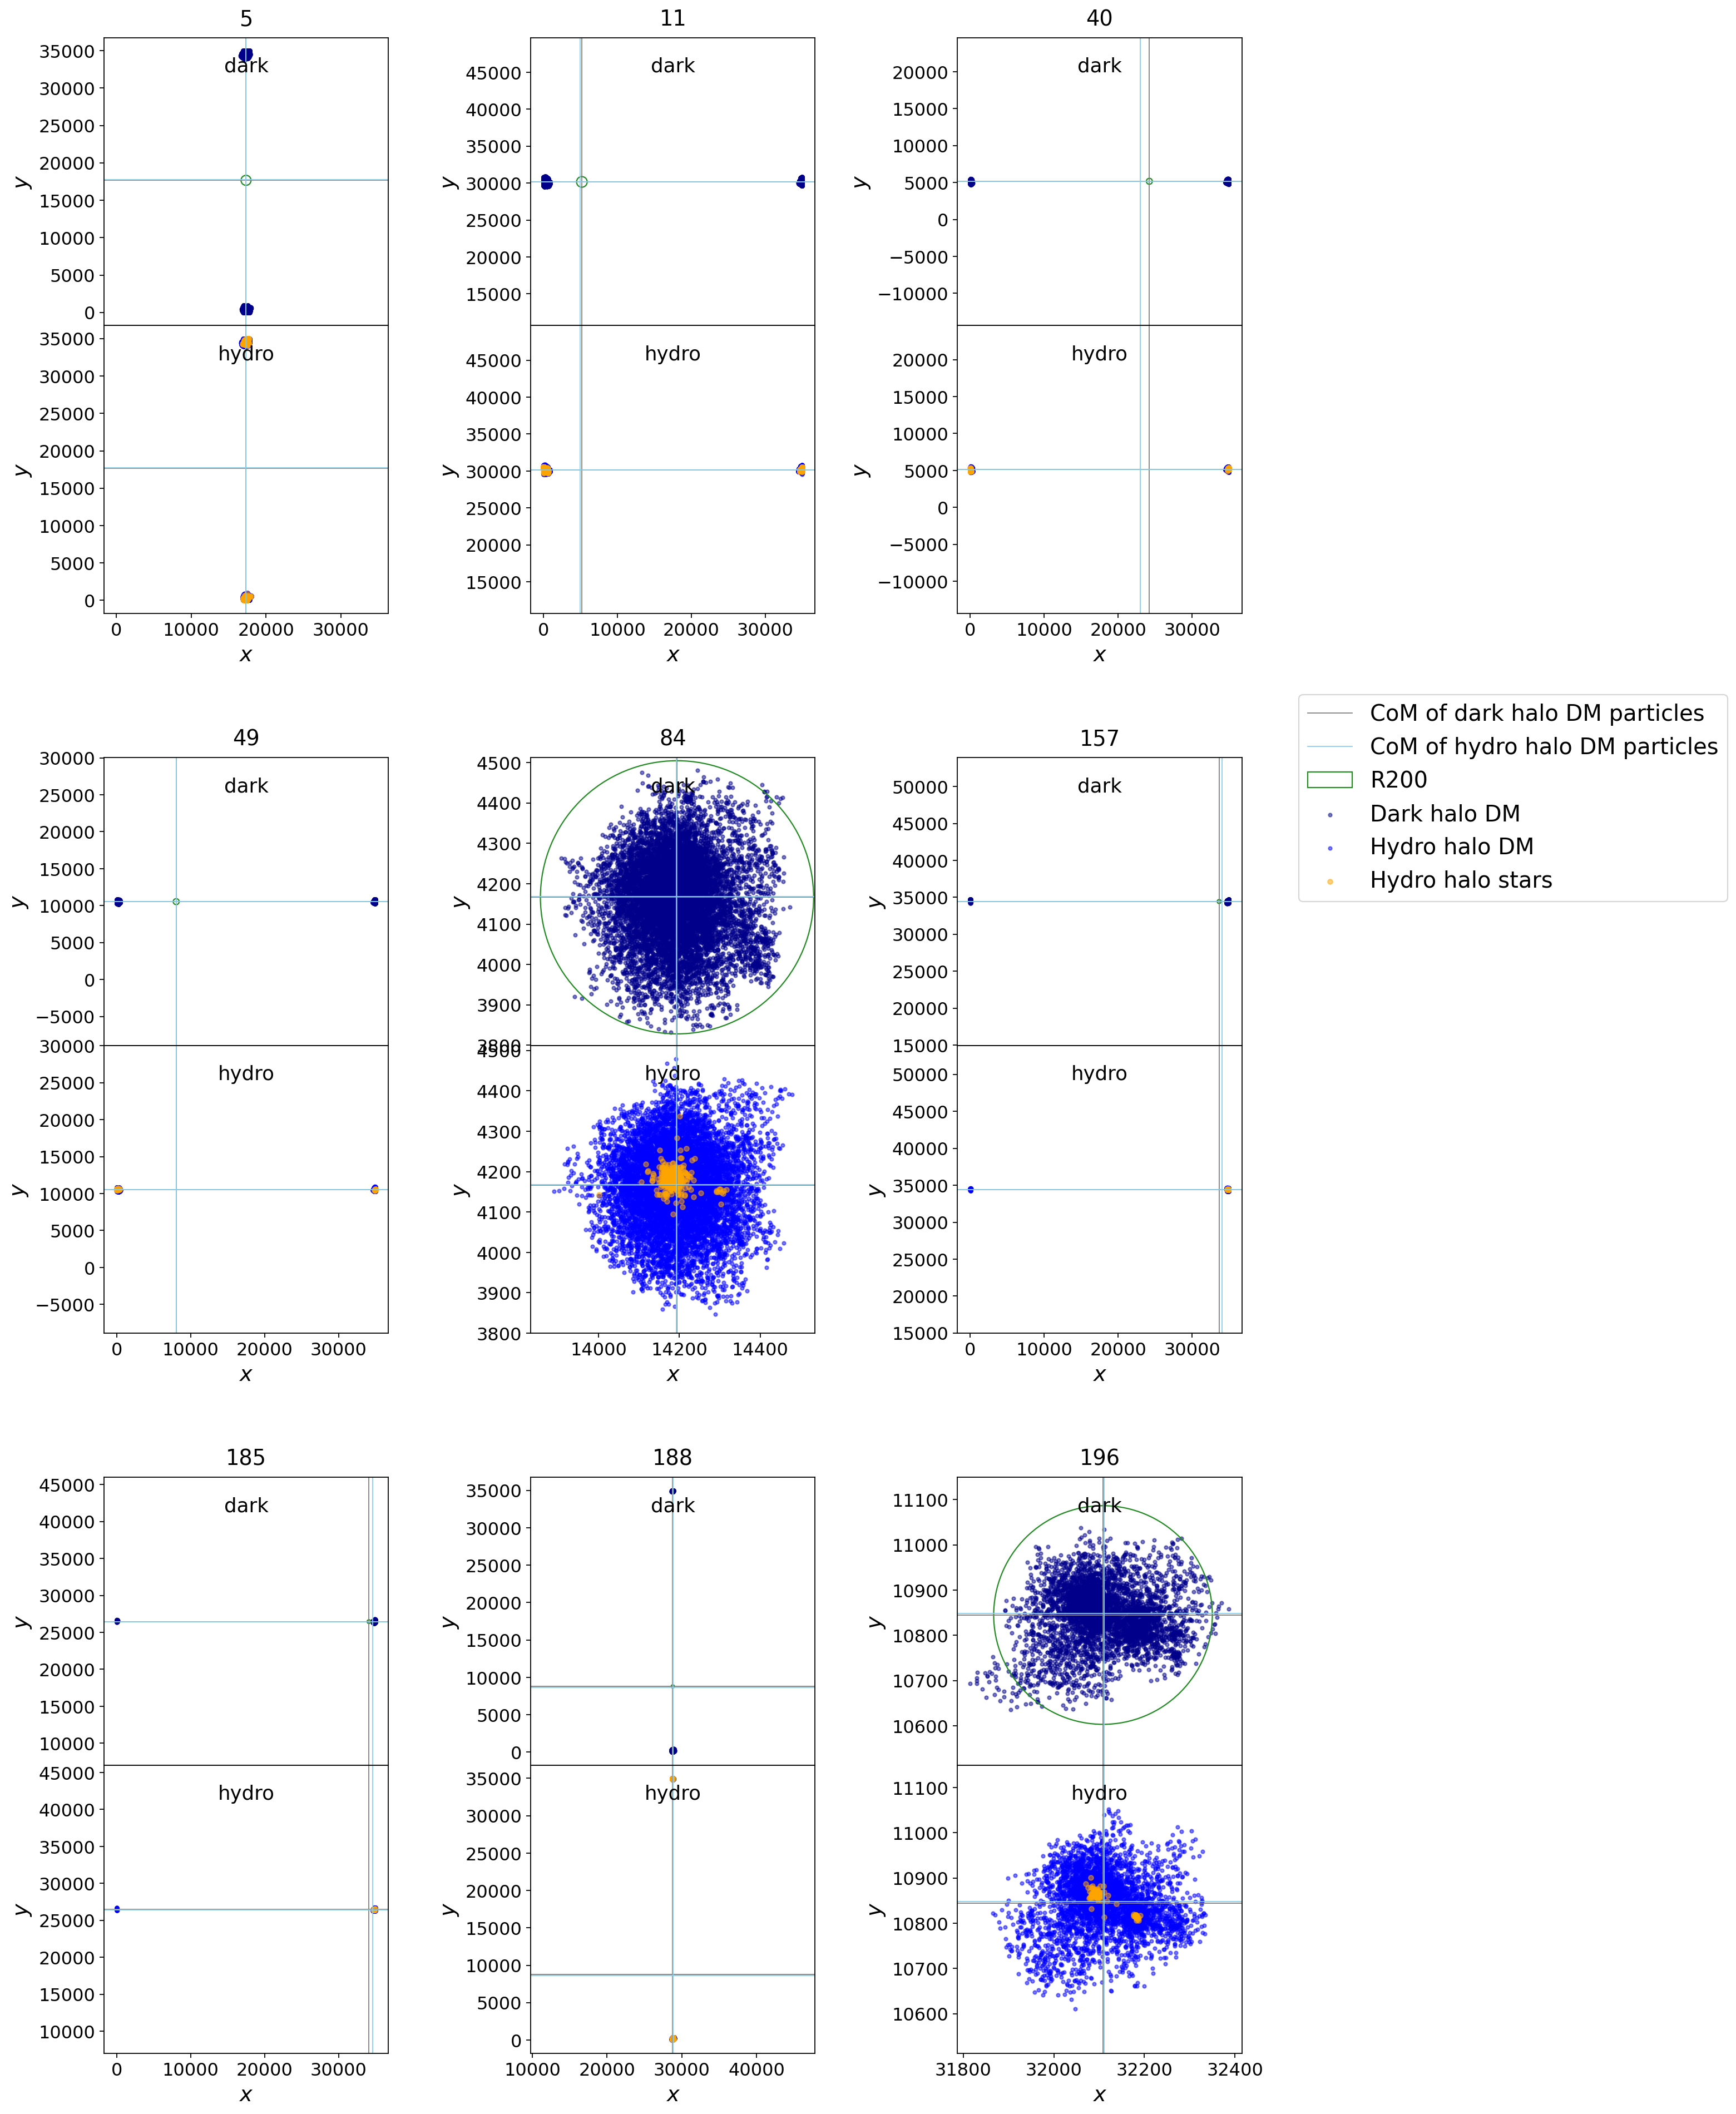

In [24]:
nrows_outer, ncols_outer = 3, 3
n_plots = nrows_outer * ncols_outer

halo_dicts_m0_zero = featurizer.halo_dicts[idxs_m0_zero][:n_plots]
titles = idxs_m0_zero[:n_plots]
print(titles)
plotter.plot_halos_dark_and_hydro(halo_dicts_m0_zero, nrows_outer, ncols_outer, titles)

In [35]:
#idx = 84 #zero, weird
idx = 350 #normal
for idx in [84, 350]:
    print(featurizer.halo_dicts[idx])
    print(featurizer.x_scalar_features[idx])
    print(featurizer.g_arrs_halos[idx])
    print(featurizer.l_arr, featurizer.n_arr, featurizer.m_dmpart)
    idx_halo_dark = featurizer.halo_dicts[idx]['idx_halo_dark']
    halo_dark_dm = il.snapshot.loadHalo(featurizer.base_path_dark,featurizer.snap_num,idx_halo_dark,'dm')
    x_halo_dark_dm = halo_dark_dm['Coordinates']
    #print(x_halo_dark_dm)
    
    x_halo_dark_dm_com = np.mean(x_halo_dark_dm, axis=0)
    print(x_halo_dark_dm_com)
    # Subtract off center of mass for each halo
    x_data_halo = x_halo_dark_dm - x_halo_dark_dm_com
    #print(x_data_halo)
    
    r_edges = featurizer.r_edges * featurizer.halo_dicts[idx]['r_mean200_dark_halo']
    g_arrs, g_normed_arrs = scalars.get_geometric_features(x_data_halo, r_edges, featurizer.l_arr, 
                                                           featurizer.n_arr, featurizer.m_dmpart)
    print(g_arrs)
    print()
    

{'idx_halo_dark': 84, 'idx_subhalo_hydro': 2591, 'idx_subhalo_dark': 2958, 'idx_halo_hydro': 82, 'r_crit200_dark_halo': 208.35466, 'r_mean200_dark_halo': 338.2132, 'mass_dark_halo_dm': 256.63855, 'mass_hydro_halo_dm': 208.67563, 'mass_hydro_halo_star': 4.277189, 'mass_hydro_subhalo_star': 4.2533507}
[1. 0.]
{0: array([0.])}
[0] [0] 0.015737226681674973
[14193.97498654  4166.31966617 29473.96108112]
[0] [5459.62815281 5462.50181933 5463.18506609 ... 5402.19200731 5278.2086203
 5396.99743068] [  0.        338.2131958] 1
window [[0. 0. 0. ... 0. 0. 0.]]
{0: array([0.])}

{'idx_halo_dark': 351, 'idx_subhalo_hydro': 3669, 'idx_subhalo_dark': 4156, 'idx_halo_hydro': 357, 'r_crit200_dark_halo': 120.62649, 'r_mean200_dark_halo': 193.64825, 'mass_dark_halo_dm': 49.32196, 'mass_hydro_halo_dm': 41.70365, 'mass_hydro_halo_star': 0.21181868, 'mass_hydro_subhalo_star': 0.21181868}
[ 1.         41.01121273]
{0: array([41.01121273])}
[0] [0] 0.015737226681674973
[23611.78383975  9542.88492066  4384.45